In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [53]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

# Count Effect

스트라이크가 3개가 되면 아웃이 되고, 볼이 4개가 되면 출루한다. 스트라이크, 볼의 카운트가 채워질수록 타석에 어떤 영향을 미치는지 분석해보았다. 21시즌 MLB Statcast 데이터를 활용하였다.

In [2]:
mlb_21=pd.read_csv('mlb_21.csv').drop('Unnamed: 0', axis=1)

## 카운트별 Expected Run Value

카운트별 기대 Run Value를 계산하였다. 이전에 계산하였던 상황(아웃카운트와 주자 상황)에 대한 Run Expectancy(RE24)를 계산했던 것과 같은 계산법으로 계산하였다. 이닝 전후의 득점 차이 대신 타석 전후의 Run Value 차이를 계산하여, 각 카운트에서의 평균 기대 Run Value를 계산하였다. 계산된 각 카운트별 기대 Run Value를 시각화하여 투수에게 유리한 카운트(기대 Run Value 음수), 타자에게 유리한 카운트(기대 Run Value 양수)를 구분하였다.

In [3]:
event_21 = mlb_21[mlb_21['events'].notnull()]

In [37]:
def calculation(event):
    total_game = pd.DataFrame()
    game_id = np.array(event['game_pk'].unique())
    for i in game_id:
        game = event[event['game_pk']==i]
        # 타석 순으로 정리
        game = game.sort_values(by='at_bat_number')

        # Start에서
        # 1B, 2B, 3B에 주자가 없을 경우, 0으로
        # 1B, 2B, 3B가 주자가 있을 경우, 1으로
        game['Start1'] = np.where(game['on_1b'].isnull(),0,1)
        game['Start2'] = np.where(game['on_2b'].isnull(),0,1)
        game['Start3'] = np.where(game['on_3b'].isnull(),0,1)

        # Start 주자 상황과 아웃카운트 병합
        game['Start_State'] = (game['Start1'].astype(str) + game['Start2'].astype(str) + game['Start3'].astype(str)+" " + game['outs_when_up'].astype(str))


        # End에서
        # 아웃카운트 계산 (이닝이 종료되었을 경우 3)
        game['end_out'] = game['outs_when_up'].shift(-1)
        game['end_out'] = np.where(game['end_out'].isnull(), 3, game['end_out'])
        game['end_out'] = np.where(((game['end_out']==0) & (game['outs_when_up']!=0)), 3, game['end_out'])
        game['end_out'] = game['end_out'].astype('int')

        # End에서
        # 1B, 2B, 3B에 주자가 없을 경우, 0으로
        # 1B, 2B, 3B가 주자가 있을 경우, 1으로
        game['end_1'] = game['Start1'].shift(-1)
        game['end_1'] = np.where((game['end_1'].isnull())|(game['end_out']==3), 0, game['end_1'])
        game['end_2'] = game['Start2'].shift(-1)
        game['end_2'] = np.where((game['end_2'].isnull())|(game['end_out']==3), 0, game['end_2'])
        game['end_3'] = game['Start3'].shift(-1)
        game['end_3'] = np.where((game['end_3'].isnull())|(game['end_out']==3), 0, game['end_3'])
        game[['end_1', 'end_2', 'end_3']]= game[['end_1', 'end_2', 'end_3']].astype('int')

        # End 주자 상황과 아웃카운트 병합
        game['End_State'] = (game['end_1'].astype(str) + game['end_2'].astype(str) + game['end_3'].astype(str)+" " + game['end_out'].astype(str))


        # 이닝당 득점한 점수 계산
        score = game.groupby(['inning', 'inning_topbot'])['bat_score'].max().reset_index().rename(columns={'bat_score': 'inning_score'})
        game = pd.merge(game, score, on=['inning', 'inning_topbot'])

        # 9회말 끝내기는 아웃카운트에 상관없이 경기가 끝나서 3아웃까지 채우지 않고도 경기가 끝나버린다.
        # 3아웃을 기준으로 측정한 run_expectancy에 영향이 가기 때문에 제외한다.
        if (game.iloc[-1]['inning_topbot']=='Bot') & (game.iloc[-1]['post_bat_score']>game.iloc[-1]['post_fld_score']):
            game.drop(game[(game['inning']==game['inning'].max()) & (game['inning_topbot']=='Bot')].index)

        # 현재 상황에서 이닝이 종료될때 까지의 득점 계산
        game['futureRun'] = game['inning_score'] - game['bat_score']


        # 모든 경기 데이터 병합
        total_game = pd.concat([total_game, game])

    return total_game

In [38]:
df_21 = calculation(event_21)

In [40]:
def run_value(df):
    start_RunExp = df.groupby(['Start_State'])['futureRun'].mean().reset_index().rename(columns={'futureRun': 'Start_RE'})
    start_RunExp = start_RunExp.append({'Start_State': '000 3', 'Start_RE': 0}, ignore_index=True)
    end_RunExp = start_RunExp.rename(columns={'Start_State':'End_State', 'Start_RE':'End_RE'})

    df = pd.merge(df, start_RunExp, on=['Start_State'], how='left')
    df = pd.merge(df, end_RunExp, on=['End_State'], how='left')


    # Run Value: 타자의 득점 + (End State와 Start State의 득점 기대값 차이)
    # 1득점당 Run Value는 1로 계산
    # 득점 = post_bat_score - bat_score
    # 타석 후의 득점 기대값의 변화량 (End_RE - Start_RE)
    df['Start_RE'] = df['Start_RE'].astype('float32')
    df['End_RE'] = df['End_RE'].astype('float32')
    df['Run_Value'] = df['post_bat_score'] - df['bat_score'] + df['End_RE'] - df['Start_RE']
    
    return df

In [41]:
rv21 = run_value(df_21)

In [43]:
rv_21 = rv21[['game_date', 'batter', 'pitcher', 'at_bat_number', 'Start_State', 'End_State', 'Start_RE', 'Run_Value']]
mlb21 = pd.merge(mlb_21, rv_21, on=['game_date', 'batter', 'pitcher', 'at_bat_number'], how='left')
mlb21 = mlb21[mlb21['balls']!=4]
mlb21['count'] = mlb21['balls'].astype('str') +'-'+ mlb21['strikes'].astype('str')

In [44]:
# 카운트별 run value 계산
rv_by_count = mlb21.groupby('count')['Run_Value'].mean().reset_index().rename(columns={'Run_Value': 'RV_exp'})
rv_by_count

,count,RV_exp
0,0-0,-0.000787
1,0-1,-0.041986
2,0-2,-0.099830
3,1-0,0.034602
4,1-1,-0.013077
5,1-2,-0.078098
6,2-0,0.099610
7,2-1,0.037483
8,2-2,-0.036956
9,3-0,0.204604


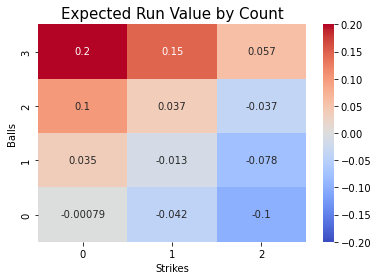

In [45]:
table1 = pd.DataFrame(np.array([rv_by_count['RV_exp'][0:3], rv_by_count['RV_exp'][3:6], rv_by_count['RV_exp'][6:9], rv_by_count['RV_exp'][9:12]]),
            columns=['0','1','2'], index=['0','1','2','3'], dtype='float')

sns.heatmap(table1.iloc[::-1], annot=True, cmap='coolwarm', vmin=-0.2, vmax=0.2)
plt.title("Expected Run Value by Count", size=15)
plt.xlabel('Strikes')
plt.ylabel('Balls')
plt.show()

위 Heatmap을 보면 카운트에 따라 Run Value 기대값이 차이가 나는 것을 확인할 수 있다. 볼 카운트가 높아질수록 Run Value 기대값이 커지고, 반대로 스트라이크 카운트가 높아질수록 Run Value 기대값이 낮아진다. Run Value 기대값 0을 기준으로 0보다 큰 카운트는 타자에게 유리한 카운트, 0보다 작은 카운트는 투수에게 유리한 카운트로 나눌 수 있다.

- 투수에게 유리한 카운트: 0-2, 1-2, 0-1, 2-2   
- 타자에게 매우 유리한 카운트: 3-0, 3-1, 2-0   
- 타자에게 유리한 카운트: 1-0, 2-1, 3-2   
- 중립 카운트: 0-0, 1-1

In [46]:
neutral = ['0-0', '1-1']
ext_hitter = ['3-0', '3-1', '2-0']
hitter = ['1-0', '2-1', '3-2']
pitcher = ['0-2', '1-2', '0-1', '2-2']

----

In [47]:
# 스윙, 헛스윙 구분
swing = ['hit_into_play', 'foul', 'swinging_strike_blocked', 'swinging_strike', 'foul_tip', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip', 'foul_pitchout']
miss = ['swinging_strike_blocked', 'swinging_strike', 'foul_tip', 'missed_bunt', 'bunt_foul_tip']

In [48]:
mlb21['swing'] = np.where(mlb21['description'].isin(swing),1,0)
mlb21['miss'] = np.where(mlb21['description'].isin(miss),1,0)
swing_miss = mlb21.groupby(['count', 'strikes', 'balls']).agg({'pitch_type': 'count', 'swing': 'sum', 'miss': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})

In [49]:
swing_miss['swing_per'] = swing_miss['swing']/swing_miss['total']
swing_miss['miss_per'] = swing_miss['miss']/swing_miss['swing']
swing_miss

,count,strikes,balls,total,swing,miss,swing_per,miss_per
0,0-0,0,0,181504,55230,14850,0.304291,0.268876
1,0-1,1,0,90589,44564,12664,0.491936,0.284176
2,0-2,2,0,48035,24893,7300,0.518226,0.293255
3,1-0,0,1,70887,30166,7986,0.425551,0.264735
4,1-1,1,1,71342,38367,10183,0.537790,0.265410
5,1-2,2,1,68225,39222,10873,0.574892,0.277217
6,2-0,0,2,24336,10349,2433,0.425255,0.235095
7,2-1,1,2,37233,21577,5205,0.579513,0.241229
8,2-2,2,2,58656,37902,9144,0.646174,0.241254
9,3-0,0,3,7713,851,152,0.110333,0.178613


In [70]:
pitcher_favor = ['0-2', '1-2', '0-1', '2-2']
batter_favor = ['3-0', '3-1', '2-0']
batter_few = ['1-0', '2-1', '3-2']
neutral = ['0-0', '1-1']

swing_miss['favor'] = np.where(swing_miss['count'].isin(pitcher_favor), '투수 유리', '')
swing_miss['favor'] = np.where(swing_miss['count'].isin(batter_favor), '타자 매우 유리', swing_miss['favor'])
swing_miss['favor'] = np.where(swing_miss['count'].isin(batter_few), '타자 유리', swing_miss['favor'])
swing_miss['favor'] = np.where(swing_miss['count'].isin(neutral), '중립', swing_miss['favor'])

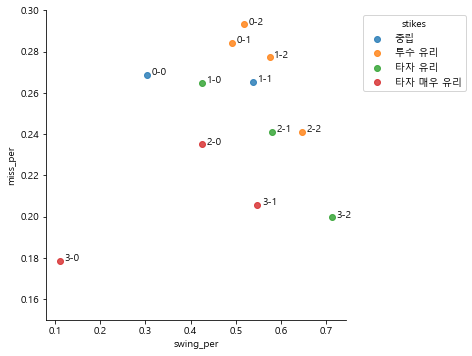

In [55]:
# 카운트별 스윙 확률, 헛스윙 비율 시각화

ax = sns.lmplot('swing_per', 'miss_per', data=swing_miss, hue='favor', fit_reg=False, size=5, aspect=1, legend=False)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.01, point['y'], str(point['val']))
label_point(swing_miss['swing_per'], swing_miss['miss_per'], swing_miss['count'], plt.gca())
plt.ylim(0.15,0.3)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='stikes')
plt.show()

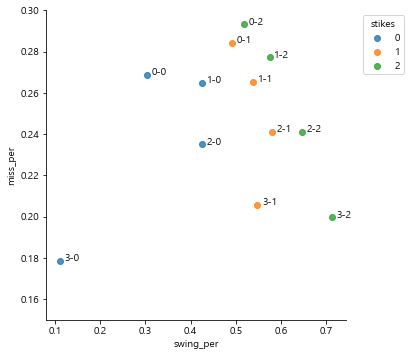

In [56]:
ax = sns.lmplot('swing_per', 'miss_per', data=swing_miss, hue='strikes', fit_reg=False, size=5, aspect=1, legend=False)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.01, point['y'], str(point['val']))
label_point(swing_miss['swing_per'], swing_miss['miss_per'], swing_miss['count'], plt.gca())
plt.ylim(0.15,0.3)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='stikes')
plt.show()

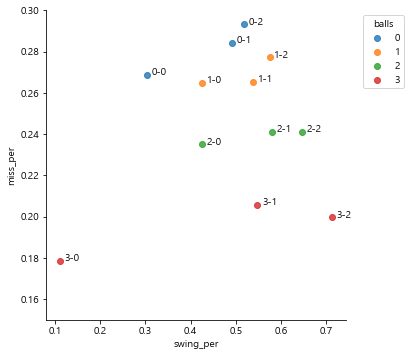

In [57]:
ax = sns.lmplot('swing_per', 'miss_per', data=swing_miss, hue='balls', fit_reg=False, size=5, aspect=1, legend=False)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.01, point['y'], str(point['val']))
label_point(swing_miss['swing_per'], swing_miss['miss_per'], swing_miss['count'], plt.gca())
plt.ylim(0.15,0.3)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='balls')
plt.show()

In [58]:
# 타자 이름 추가
player_ids = np.array(mlb21['batter'])
batter = pyb.playerid_reverse_lookup(player_ids, key_type='mlbam')
batter['batter_name'] = batter['name_first'] + ' ' + batter['name_last']
batter_name = batter[['batter_name', 'key_mlbam']].rename(columns={'key_mlbam': 'batter'})
mlb21 = pd.merge(mlb21, batter_name, on='batter')

In [59]:
# 후안 소토
soto = mlb21[mlb21['batter_name']=='juan soto']
soto_count = soto.groupby(['count', 'strikes', 'balls']).agg({'pitch_type': 'count', 'swing': 'sum', 'miss': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})
soto_count['swing_per'] = soto_count['swing']/soto_count['total']
soto_count['miss_per'] = soto_count['miss']/soto_count['swing']
soto_count['type'] = 'juan soto'

In [60]:
# 브라이스 하퍼
harper = mlb21[mlb21['batter_name']=='bryce harper']
haper_count = harper.groupby(['count', 'strikes', 'balls']).agg({'pitch_type': 'count', 'swing': 'sum', 'miss': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})
haper_count['swing_per'] = haper_count['swing']/haper_count['total']
haper_count['miss_per'] = haper_count['miss']/haper_count['swing']
haper_count['type'] = 'bryce harper'

In [61]:
# 오타니 쇼헤이
ohtani = mlb21[mlb21['batter_name']=='shohei ohtani']
ohtani_count = ohtani.groupby(['count', 'strikes', 'balls']).agg({'pitch_type': 'count', 'swing': 'sum', 'miss': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})
ohtani_count['swing_per'] = ohtani_count['swing']/ohtani_count['total']
ohtani_count['miss_per'] = ohtani_count['miss']/ohtani_count['swing']
ohtani_count['type'] = 'shohei ohtani'

swing_miss['type'] = 'avg'

comp = pd.concat([swing_miss, ohtani_count, soto_count])

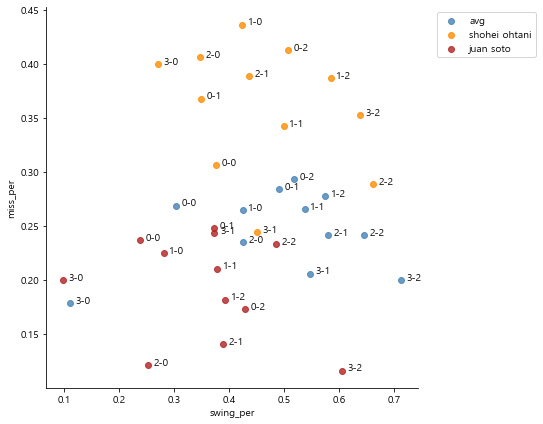

In [62]:
# 선수별 스윙, 헛스윙 비율 확인

ax = sns.lmplot('swing_per', 'miss_per', data=comp, hue='type', palette=['steelblue', 'darkorange', 'firebrick'], fit_reg=False, size=6, aspect=1, legend=False)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.01, point['y'], str(point['val']))
label_point(comp['swing_per'], comp['miss_per'], comp['count'], plt.gca())
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [63]:
# 구종 구분
fastball = ['4-Seam Fastball', 'Cutter', 'Sinker', 'Fastball']
offspeed = ['Split-Finger', 'Changeup', 'Screwball']
breaking = ['Slider', 'Curveball', 'Knuckle Curve', 'Knuckleball', 'Eephus']

mlb21['fastball'] = np.where(mlb21['pitch_name'].isin(fastball), 1, 0)
mlb21['offspeed'] = np.where(mlb21['pitch_name'].isin(offspeed), 1, 0)
mlb21['breaking'] = np.where(mlb21['pitch_name'].isin(breaking), 1, 0)

In [64]:
pitch_type = mlb21.groupby(['count', 'strikes', 'balls']).agg({'pitch_type': 'count', 'fastball': 'sum', 'offspeed': 'sum', 'breaking': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})
pitch_type['fastball_per'] = pitch_type['fastball']/pitch_type['total']
pitch_type['nonfast_per'] = (pitch_type['offspeed']+pitch_type['breaking'])/pitch_type['total']
pitch_type

,count,strikes,balls,total,fastball,offspeed,breaking,fastball_per,nonfast_per
0,0-0,0,0,181504,111889,15206,54409,0.616455,0.383545
1,0-1,1,0,90589,47652,13931,29006,0.526024,0.473976
2,0-2,2,0,48035,22718,6488,18829,0.472947,0.527053
3,1-0,0,1,70887,43716,10114,17057,0.616700,0.383300
4,1-1,1,1,71342,37752,12354,21236,0.529169,0.470831
5,1-2,2,1,68225,32324,10288,25613,0.473785,0.526215
6,2-0,0,2,24336,17722,2733,3881,0.728222,0.271778
7,2-1,1,2,37233,22899,5621,8713,0.615019,0.384981
8,2-2,2,2,58656,30168,9171,19317,0.514321,0.485679
9,3-0,0,3,7713,7341,144,228,0.951770,0.048230


In [65]:
pitch_type['favor'] = np.where(pitch_type['count'].isin(pitcher_favor), '투수 유리', '')
pitch_type['favor'] = np.where(pitch_type['count'].isin(batter_favor), '타자 매우 유리', pitch_type['favor'])
pitch_type['favor'] = np.where(pitch_type['count'].isin(batter_few), '타자 유리', pitch_type['favor'])
pitch_type['favor'] = np.where(pitch_type['count'].isin(neutral), '중립', pitch_type['favor'])

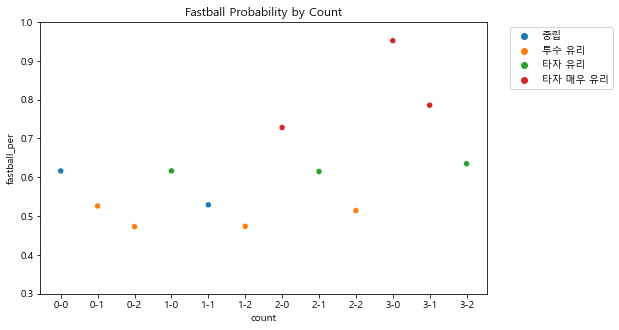

In [66]:
# 카운트에 따른 패스트볼 확률 확인
plt.figure(figsize=(8,5))
sns.scatterplot(data=pitch_type, x='count', y='fastball_per', hue='favor')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylim(0.3, 1)
plt.title("Fastball Probability by Count")
plt.show()

In [67]:
# 오타니 데이터
pitch_type_p = mlb21.groupby(['player_name', 'count', 'strikes', 'balls']).agg({'pitch_type': 'count', 'fastball': 'sum', 'offspeed': 'sum', 'breaking': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})
ohtani = pitch_type_p[pitch_type_p['player_name']=='Ohtani, Shohei']
ohtani['fastball_per'] = ohtani['fastball']/ohtani['total']
ohtani['nonfast_per'] = (ohtani['offspeed']+ohtani['breaking'])/ohtani['total']
ohtani['favor'] = np.where(ohtani['count'].isin(pitcher_favor), '투수 유리', '')
ohtani['favor'] = np.where(ohtani['count'].isin(batter_favor), '타자 매우 유리', ohtani['favor'])
ohtani['favor'] = np.where(ohtani['count'].isin(batter_few), '타자 유리', ohtani['favor'])
ohtani['favor'] = np.where(ohtani['count'].isin(neutral), '중립', ohtani['favor'])

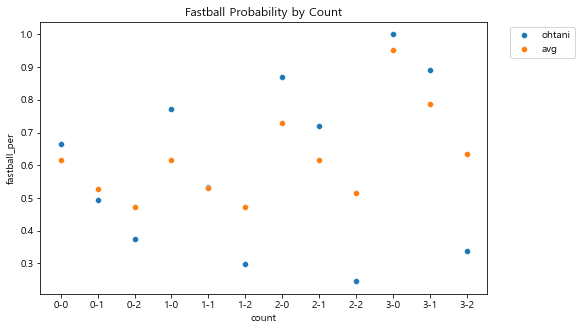

In [68]:
# 오타니와 평균 비교
plt.figure(figsize=(8,5))
sns.scatterplot(data=ohtani, x='count', y='fastball_per', label='ohtani')
#sns.scatterplot(data=snell, x='count', y='fastball_per', label='snell')
sns.scatterplot(data=pitch_type, x='count', y='fastball_per', label='avg')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
#plt.ylim(0.3, 1)
plt.title("Fastball Probability by Count")
plt.show()

----

### Reference

Max Marchi, *Analyzing Baseball data with R* (Chapman & Hall/CRC The R Series), 2018